<h1 align='center'> COMP2420/COMP6420 - Introduction to Data Management, Analysis and Security</h1>

<h2 align='center'> Lab 06 - Decision Trees & Clustering</h2>
<h5 align='center'><sub> Author: Afzal Ahmad, 2020 </sub></h5>

*****

## Note
Dear Students, Please do not worry if you are finding it difficult to finish all the lab exercises during the allocated time. The labs were designed to help you think about the weekly topic being studied in depth and contain exercises in increasing order of complexity. You can finish what's left in your free time at home or in the computer labs on campus. If you need input, please go to the drop-in sessions available weekly and/or post your questions on Piazza.
***

## Aim
There are three main aims in this lab:
- Introduce you to the Decision Tree algorithm
- Describe the difference between supervised and unsupervised algorithms
- Introduce the Clustering algorithm as an unsupervised algorithm
*****

## Learning Outcomes
The following course learning outcomes apply to this lab:
- L03: Demonstrate basic knowledge and understanding of descriptive and predictive data analysis methods, optimization and search, and knowledge representation.
- L04: Formulate and extract descriptive and predictive statistics from data
- L05: Analyse and interpret results from descriptive and predictive data analysis
- L06: Apply their knowledge to a given problem domain and articulate potential data analysis problems

***

## Preparation

Before starting this lab, we suggest you complete the following:
- Watch the lectures this week
- Complete both Lab04 (regression) and Lab05 (classification) and become familiar with both categories of techniques


The following functions may be useful for this lab:

| Function                     | Description |
| ---:                         | :---        |
| `DecisionTreeClassifier`, `DecisionTreeRegressor`              | create instances of the respective Decision Tree modules |
| `tree.export_graphviz(model, output)`         | export `model`'s tree construction to the `output` file |
| `KMeans()`, `PCA()`  | create instances of the K-Means Classifier and Principle Components Analysis modules |
| `kmc_model.labels_` | returns `N` cluster labels, where `N` is the number of observations in the fitted data |
| `kmc_model.cluster_centers_` | returns `K` cluster centres, where `K` is the number of clusters

***

In [1]:
# code imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder            # encooding variables
from sklearn.preprocessing import StandardScaler          # Scaling variables
from sklearn.model_selection import train_test_split      # testing our models
from sklearn.model_selection import cross_validate        # cross validation
from sklearn.model_selection import cross_val_score       # cross-validation
from sklearn.model_selection import KFold                 # Scikit-learn K-Folds cross-validator
k_fold = KFold(n_splits=10, shuffle=True, random_state=0) # KFold configuration
from sklearn.model_selection import GridSearchCV          # GridSearch
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

# decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# k-means clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt    # plotting, if you need it
import seaborn as sns
plt.style.use('seaborn')

np.random.seed(5123690)

### Exercise 1: Planting Roots

We've still got one more **supervised** (more on this later, if you're not already familiar) machine learning algorithm to introduce: **Decision Trees**. This is because it's a versatile algorithm; it can be used for **both numerical regression and categorical classification**. Before we dive into it, let's go through some terminology:
- a Decision Tree consists of **nodes** and **branches**, and (like most trees you'll see in computer science) looks like an upside-down tree, with the starting point at the top and the branches growing downwards
- the "starting point" is called the **root node**, and this represents the whole set of observations in the data
- intermediate nodes, called a **decision node**, is a node that represents a subset of the observations
- each "ending point" is called a **leaf node**, or terminal node, and is defined as a node that has no branches leading (downwards) from it
- each non-leaf node will have (usually two) **branches**, with each branch representing a decision - for example, the left branch might split the data dependent on `Age<=10` and thus the right branch will have the remaining data, with `Age>10`

The Decision Tree algorithm will try to choose these branches so that the training data in the leaf nodes are homogenous. As an example, suppose you have a two-class classification, `Survival` = 0 or 1. The algorithm will try to construct the tree so that each leaf node has either all 0s or all 1s as the targets.

How does it do this? Using metrics called **Entropy** and **Information Gain**. Loosely, the entropy of a set of information is based on how similar all points are; when all information points have the same value(s), entropy is 0, and when all information points have unique value(s) entropy is maximised. In the context of Decision Trees, the algorithm tries to minimise the entropy of the information in each leaf node. Thus, at each decision node, it maximises the Information Gain, which is the difference between the entropy before the split and the entropy after splitting.



### Exercise 2: Classifying Trees

Time to use Decision Trees for a classification problem. Because we've been using the Titanic dataset in Lab05, let's use it again. Here's the description of the columns, in case you need to refer to them:

| Name           | Description |
| ---:           | :---        |
| `PassengerId`  | an arbitrary ID assigned to each passenger |
| `Survived`     | status of passenger's survival<br>(`0`=No, `1`=Yes) |
| `Pclass`       | passenger's ticket class<br>(`1`=Upper, `2`=Middle, `3`=Lower) |
| `Name`         | full title and name of passenger |
| `Sex`          | gender of passenger |
| `Age`          | age of passenger<br>fractional if less than 1, xx.5 if estimated |
| `SibSp`        | number of siblings and spouses aboard<br>brother / sister / stepbrother / stepsister / husband / wife |
| `Parch`        | number of parents and children aboard<br>mother / father / daughter / son / stepdaughter / stepson |
| `Ticket`       | ticket ID |
| `Fare`         | passenger fare ($) |
| `Cabin`        | cabin number |
| `Embarked`     | port of embarkation<br>(`C`=Cherbourg, `Q`=Queenstown, `S`=Southampton) |

#### 2.1 I Tried So Hard, And Got So Far

The `DecisionTreeClassifier` module is very similar to other Scikit-Learn modules you've been using. Import the data, transform your data to prepare it for classification, create a Decision Tree module instance, split the data, fit the model using the training data, and score the model on both the training and testing sets. In short: **import**, **prepare**, **split**, **fit**, **score**. Maybe you can make a rhyme out of that.

In [2]:
# TODO: IMPORT
titanic = pd.read_csv("data/titanic.csv")

In [3]:
# TODO: PREPARE
titanic = titanic.drop(columns=['Cabin', 'Name', 'Ticket'], axis=1)
titanic = titanic.fillna(titanic.mean(numeric_only=True))
titanic['Embarked'] = titanic['Embarked'].fillna("S")

labelEncoder = LabelEncoder()
# 1 is male, 0 is female
titanic['Sex'] = labelEncoder.fit_transform(titanic['Sex'])
titanic['Embarked'] = labelEncoder.fit_transform(titanic['Embarked'])

if titanic.isnull().sum().sum() == 0:
    print('No more nan values.')
else:
    print('There are still some missing values.')
    
# Rearrange column for later density graphing
titanic = titanic[['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex','Embarked', 'Survived']]

# Scale the data
titanic_scaled = titanic.copy()
standardScaler = StandardScaler()
# scale fare, passengerID and age
cols = ['Fare', 'PassengerId', 'Age']
titanic_scaled[cols] = standardScaler.fit_transform(titanic[cols])
titanic_scaled.describe()

No more nan values.


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Survived
count,8.910000e+02,891.000000,8.910000e+02,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000
mean,2.517004e-17,2.308642,2.562796e-16,0.523008,0.381594,-4.373606e-17,0.647587,1.536476,0.383838
std,1.000562e+00,0.836071,1.000562e+00,1.102743,0.806057,1.000562e+00,0.477990,0.791503,0.486592
min,-1.730108e+00,1.000000,-2.253155e+00,0.000000,0.000000,-6.484217e-01,0.000000,0.000000,0.000000
25%,-8.650540e-01,2.000000,-5.924806e-01,0.000000,0.000000,-4.891482e-01,0.000000,1.000000,0.000000
50%,0.000000e+00,3.000000,0.000000e+00,0.000000,0.000000,-3.573909e-01,1.000000,2.000000,0.000000
75%,8.650540e-01,3.000000,4.079260e-01,1.000000,0.000000,-2.424635e-02,1.000000,2.000000,1.000000
max,1.730108e+00,3.000000,3.870872e+00,8.000000,6.000000,9.667167e+00,1.000000,2.000000,1.000000


In [4]:
# TODO: SPLIT
# Selecting the features
X = titanic_scaled.iloc[:, :-1].values # feature variables
y = titanic_scaled.iloc[:, -1].values  # target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [5]:
# TODO: FIT
decisionTree = DecisionTreeClassifier()
decisionTree_model = decisionTree.fit(X_train, y_train)

In [71]:
# TODO: SCORE
print("Training set score: {:.3f}".format(decisionTree.score(X_train,y_train)))
print("Test set score: {:.3f}".format(decisionTree.score(X_test,y_test)))
print("Cross validated scores:",(cross_val_score(decisionTree, X_train, y_train, cv=k_fold).mean()))

Training set score: 0.876
Test set score: 0.838
Cross validated scores: 0.8048708920187793


Notice anything interesting? Unless you changed the parameters of the `DecisionTreeClassifier`, you'll likely find that your training score and your testing scores differ significantly. Why might that be?

#### 2.2 But In The End, It Didn't Even Matter

Luckily, you can view the actual tree that the algorithm created. To do this, run `tree.export_graphviz(<model>, "tree.dot")`, where `<model>` is the name of the Decision Tree model you created.

In [7]:
# TODO: export tree
tree.export_graphviz(decisionTree_model, "tree.dot")

Now there's the question of compiling the exported `.dot` file into an image that you can read. This is optional, but highly recommended to understand how Decision Trees work. There's a few ways you can do this:
- Set up the tools on your machine to be able to convert it in the terminal (note that **this is unlikely to work on the CECS lab computers**):
    - Ubuntu
        1. `sudo apt install graphviz`
        2. `dot -Tpng tree.dot -o tree.png` (in the correct directory)
    - OSX (using Homebrew)
        1. `brew install graphviz`
        2. `dot -Tpng tree.dot -o tree.png` (in the correct directory)
    - Windows
        1. Install the appropriate packages from [GraphViz on Gitlab](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)
        2. Ensure GraphViz is within your PATH
        3. In PowerShell: `dot -Tpng tree.dot -o tree.png` (in the correct directory)
- Use an online converter which takes the `.dot` file and outputs a `.png` file. One such example is [this website](https://onlineconvertfree.com/convert-format/dot-to-png/). However, **be aware that you are responsible for any risks** that you take in using this or other services.

If you were able to obtain the image of the tree construction successfully, analyse it. In particular, look at the leaf nodes and the `samples` and `values` for each leaf. What do you notice, and why might this affect the testing score?

If you weren't able to look at the tree, the short story is that the leaf nodes contained (mostly) only values that belonged to one target value (i.e. data relating to each node was usually either all `Survived`=1 or `Survived`=0. Of course, we shouldn't expect anything else - the Decision Tree algorithm is to do exactly that. As a result, the tree was also incredibly large, and up to 20 layers deep. 

What does this lead to? The kryptonite of machine learning: **overfitting**. Let's look at how to combat this.

Use `help(DecisionTreeClassifier)` to look at the parameters available when fitting a model. In particular, look at `max_depth`, `min_samples_split` and `min_samples_leaf`, and see how these might affect the construction of the model's tree.

In [8]:
# TODO: investigate the algorithm parameters
help(DecisionTreeClassifier)

#### 2.3 Let's See How Far We've Come

Re-fit the model and find the training and testing scores, but this time set the parameters for `max_depth`, `min_samples_split` and/or `min_samples_leaf` to avoid overfitting. If you get stuck, export the model and view the tree to see how you can improve it.

In [73]:
# TODO: RE-FIT the model with parameters and SCORE
decisionTree = DecisionTreeClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=6)
decisionTree_model = decisionTree.fit(X_train, y_train)

print("Training set score: {:.3f}".format(decisionTree.score(X_train,y_train)))
print("Test set score: {:.3f}".format(decisionTree.score(X_test,y_test)))
print("Cross validated scores:",(cross_val_score(decisionTree, X_train, y_train, cv=k_fold).mean()))

Training set score: 0.876
Test set score: 0.838
Cross validated scores: 0.8048708920187793


You'll likely still find that the training score is higher than the testing score, but it should be much more indicative than it was before. Careful not to be too specific with these parameters, as this can lead to treating the testing set like a second training set to maximise.

#### 2.4 Find the best parameter: cross validation and grid search

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set ```test_X```, ```test_y```. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally. Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by **grid search** techniques.


<img src="./grid_search_workflow.png" alt="grid_search_flow" width="600"/>

When evaluating different settings (“hyperparameters”) for estimators, such as the ```C``` setting that must be manually set for a decision tree, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called **cross-validation** (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;

the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small. (https://scikit-learn.org/stable/modules/cross_validation.html)

<img src="./grid_search_cross_validation.png" alt="grid_search_flow" width="600"/>

#### 2.4.1 Now, let's see how to use cross validation to evaluate the models we build for 2.1 and 2.3.

In [90]:
dt = DecisionTreeClassifier()
scores = cross_validate(dt, X_train, y_train, cv=5 ,scoring='accuracy')
print(f"the 5 fold average cross validation score of model in 2.1 is {np.mean(scores['test_score']):.4f}")

dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=10)
scores = cross_validate(dt, X_train, y_train, cv=5 ,scoring='accuracy')
print(f"the 5 fold average cross validation score of model in 2.3 is {np.mean(scores['test_score']):.4f}")

the 5 fold average cross validation score of model in 2.1 is 0.7332
the 5 fold average cross validation score of model in 2.3 is 0.8090


#### 2.4.2 Now, let's first determine the hyperparameters range you want to search.
For this is the first time we do a grid search over parameters, we have done it for you.

In [79]:
hyperparameters_dict = {'max_depth': range(2,20,2),
                   'min_samples_split': range(2, 20, 2), 
                   'min_samples_leaf': range(2, 20, 2) }

##### Todo: How many train-test iterations will be needed if you want to do a 5-fold cross validation for each of the parameter combinations in ```hyperparameters_dict```?

len(list(range(2,20,2)))*3 5= 3645. As you can see it is very computationally expansive.

#### 2.4.3 Do a grid search for all the combination in the ```hyperparameters_dict```
    1. report the best parameter combination you find.
    2. report the best average accuracy you find for the best parameter combination.

In [82]:
%%time
# TODO: fill in the blank
best_score = -1
best_parameter = {'max_depth': 0,
                   'min_samples_split': 0, 
                   'min_samples_leaf': 0 }

for max_depth in hyperparameters_dict['max_depth']:
    for min_samples_split in hyperparameters_dict['min_samples_split']:
        for min_samples_leaf in hyperparameters_dict['min_samples_leaf']:
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            
            scores = cross_validate(dt, X_train, y_train, cv=5 ,scoring='accuracy')['test_score']
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_parameter['max_depth'] = max_depth
                best_parameter['min_samples_split'] = min_samples_split
                best_parameter['min_samples_leaf'] = min_samples_leaf
                best_score = mean_score
                
print(f'the best model parameter: {best_parameter} and the best mean accuracy: {best_score:.4f}')

the best model parameter: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 14} and the best mean accuracy: 0.8174
Wall time: 5.62 s


#### 2.4.5 Now use the best set of parameter and train on the ```train_x``` set and test it again on the ```test_x``` data set we created in 2.1

In [84]:
#TODO: train the model with best set of the parameters and evaluate the train and test score
dt_best = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=14)
dt_best_model = dt_best.fit(X_train, y_train)
print("Best Model Training Score:", dt_best_model.score(X_train, y_train))
print("Best Model Testing Score: ", dt_best_model.score(X_test, y_test))

Best Model Training Score: 0.8469101123595506
Best Model Testing Score:  0.7988826815642458


#### Using SKlearn's GridSearchCV for all the combination in the ```hyperparameters_dict```

In [96]:
%%time
# Create a list of hyperparameters dictionary
hyperparameters = {'max_depth': range(2,20,2),
                   'min_samples_split': range(2, 20, 2), 
                   'min_samples_leaf': range(2, 20, 2) }

# Instantiate the model
decisionTree = DecisionTreeClassifier()

# Instantiate  GridSearchCV and pass in the parameters
gridSearch = GridSearchCV(decisionTree, hyperparameters, scoring='accuracy')

# Fit 
best_model = gridSearch.fit(X_train, y_train)
print("The best parameters are:", best_model.best_params_)

The best parameters are: {'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 2}
Wall time: 5.49 s


In [4]:
l = range(2,20,2)
print(type(l))

<class 'range'>


In [98]:
# Predict values based on new parameters
best_y_pred = best_model.predict(X_test)
# best model evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,best_y_pred)))
print('Precision Score : ' + str(precision_score(y_test,best_y_pred)))
print('Recall Score : ' + str(recall_score(y_test,best_y_pred)))
print('F1 Score : ' + str(f1_score(y_test,best_y_pred)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,best_y_pred)

Accuracy Score : 0.7988826815642458
Precision Score : 0.7714285714285715
Recall Score : 0.7297297297297297
F1 Score : 0.75


array([[89, 16],
       [20, 54]], dtype=int64)

Compare this testing score to the score you got in Lab05 - which is higher? Of course, keep in mind that no single machine learning algorithm is better than the rest; each has their advantages and disadvantages depending on the data that they're given.

If you haven't already done so, export the tree and view it if possible. How does it differ from the classifying tree?

In [95]:
# TODO: export and view, if possible
tree.export_graphviz(decisionTree_model, "best_model_tree.dot")
# dot -Tpng tree.dot -o tree.png in terminal

### Exercise 3: No More Adult Supervision

#### 3.1 Supervised vs Unsupervised

So far, all of the machine learning algorithms (linear regression, logistic regression, kNN and Decision Trees) have been **supervised** algorithms. If you're not already familiar, a supervised algorithm **requires that the target is labelled**. For example, we've been using the Titanic dataset which has `Survived` as either `0` or `1` for each person. The name "supervised" comes from the idea that you, the supervisor, have given it everything it needs to work with.

This is in contrast to **semi-supervised** (not covered in this course) and **unsupervised** algorithms. Unsupervised algorithms have **no labelled target values**, and it's the job of the algorithm to categorise the data so that you can determine what label each category is. One example that we'll see soon is a scenario where a store wants to categorise customers so that they can understand the distinct types of shoppers that visit their store, and potentially advertise relevant products towards them.

The unsupervised algorithm we'll be teaching in this course is **K-Means Clustering**. This splits the data into a specified number of clusters to be analysed by you later. **Don't get mixed up between k-Nearest Neighbour and K-Means Clustering**, especially because both are graphical, distance-based algorithms that use a `K` parameter as one of its main aspects.

#### 3.2 Iris Clusters

Let's start off easy. Import the Iris dataset (`data/IRIS.csv`) and **perform a clustering based on all the columns except the `species` column**. When creating the module instance, set `n_clusters=3` (why?). **Save the model with the name `kmc_model`**. Don't worry about splitting or testing your data - after all, unsupervised algorithms have no target labels to test with.

In [13]:
# TODO: import and fit
iris = pd.read_csv('data/IRIS.csv')
iris_data = iris.iloc[:, :-1].values
kmc = KMeans(n_clusters=3)
kmc_model = kmc.fit(iris_data)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


If you've fit the model with the correct name, you should be able to use the next code block to plot your clusters. Change `dim_1` and `dim_2` to look at the data using different features (essentially, looking at it from a different angle). After you've explored that, change the `n_clusters` parameter above to a different number to see how that changes the clustering.

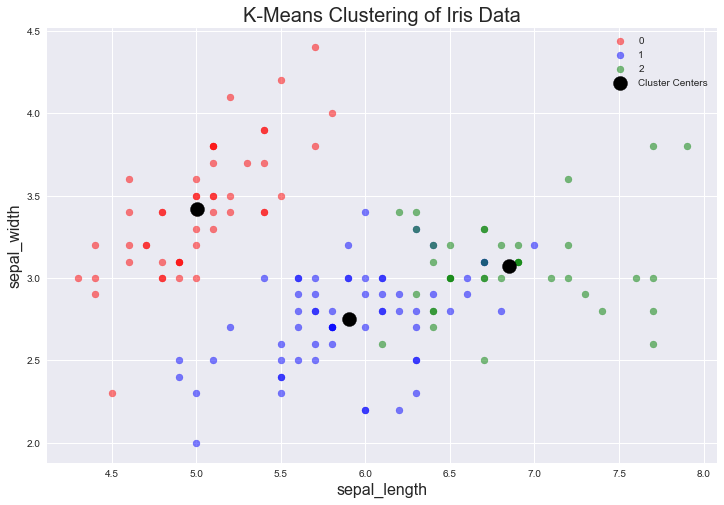

In [14]:
# feel free to change the colours to your liking
colors=["red","blue","green","purple","orange"]
dim_1 = 0    # change, between 0 and 3
dim_2 = 1    # between 0 and 3, dim_2!=dim_1

# plotting with different coloured clusters and showing cluster centres
plt.figure(figsize=(12,8))
for i in range(np.max(kmc_model.labels_)+1):
    plt.scatter(iris[kmc_model.labels_==i].iloc[:,dim_1], iris[kmc_model.labels_==i].iloc[:,dim_2], label=i, c=colors[i], alpha=0.5)
plt.scatter(kmc_model.cluster_centers_[:,dim_1], kmc_model.cluster_centers_[:,dim_2], label='Cluster Centers', c="black", s=200)
plt.title("K-Means Clustering of Iris Data",size=20)
plt.xlabel(iris.columns[dim_1], size=16)
plt.ylabel(iris.columns[dim_2], size=16)
plt.legend()
plt.show()

Explore the data and compare the `species` label to the `kmc_model.labels_` label. Do the labels accurately categorise the species?

In [4]:
# TODO: explore data vs clusters
for i in range(np.max(kmc_model.labels_)+1):
    unique, counts = np.unique(iris[kmc_model.labels_==i]["species"], return_counts=True)
    print(np.asarray((unique, counts)), "\n")

[['Iris-setosa']
 [50]] 

[['Iris-versicolor' 'Iris-virginica']
 [26 13]] 

[['Iris-virginica']
 [12]] 

[['Iris-virginica']
 [24]] 

[['Iris-versicolor' 'Iris-virginica']
 [24 1]] 



Frustrated that you can only see in two dimensions on a screen at a time? What if you had 10 variables to look at? That'd give you 45 different angles to look at the clusters from!

Fortunately, we can reduce the dimensionality of the data using **Principle Components Analysis** (PCA), allowing you to look at the data from the "best" angle. PCA decomposes all of the variables into the desired number of dimensions that maximise the variance between them. As a result, you can look at the data on a screen that can only show two dimensions, but it also means that the dimensions that you view the data at doesn't have much meaning in the context of the data.

Use the `PCA` module in Scikit-Learn to **reduce the data down to two dimensions**, using the `fit_transform` function with `n_components=2`. Be sure to exclude the `species` column beforehand. Save the decomposition to an object called `iris_reduced`.

In [5]:
# TODO: decompose the iris data
pca = PCA(n_components=2)
iris_reduced = pca.fit_transform(iris.iloc[:,:-1])

Now redo the clustering above using the `iris_reduced` data, and run the code block below to plot the data.

In [6]:
# TODO: re-cluster
kmc = KMeans(n_clusters=3)
kmc_model = kmc.fit(iris_reduced)

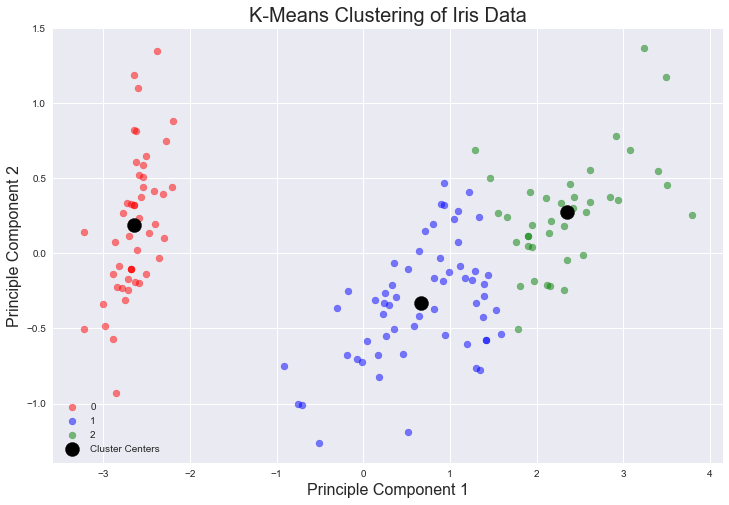

In [7]:
# feel free to change the colours to your liking
colors=["red","blue","green","purple","orange"]

# plotting with different coloured clusters and showing cluster centres
plt.figure(figsize=(12,8))
for i in range(np.max(kmc_model.labels_)+1):
    plt.scatter(iris_reduced[kmc_model.labels_==i][:,0], iris_reduced[kmc_model.labels_==i][:,1], label=i, c=colors[i], alpha=0.5)
plt.scatter(kmc_model.cluster_centers_[:,0], kmc_model.cluster_centers_[:,1], label='Cluster Centers', c="black", s=200)
plt.title("K-Means Clustering of Iris Data",size=20)
plt.xlabel("Principle Component 1", size=16)
plt.ylabel("Principle Component 2", size=16)
plt.legend()
plt.show()

Now you can see the data from the best angle, without needing to look at it with different dimensions to make sure the clustering is well-separated. You might not see much difference here, but it'll certainly help as you move on to more complicated datasets.

#### 3.3 Crowds of Customers

Let's do the same as above, but this time we'll be working on customer data.

Import the data (`data/customers.csv`) and perform a clustering on the reduced data (i.e. after using PCA). We leave it up to you to **decide how many clusters you should create**, as realistically this is usually not given to you. Ideally, you should **maximise the distance between clusters**, and **minimise the distance within clusters**.

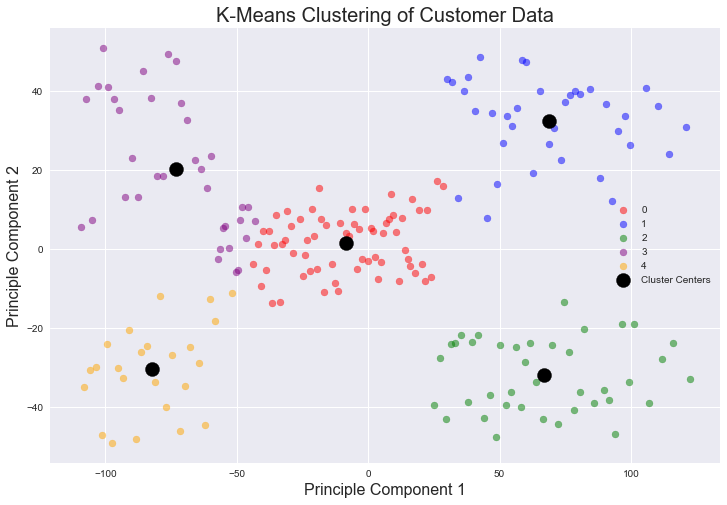

In [8]:
# TODO: create clustering for customers data
# import
customers = pd.read_csv("data/customers.csv")

# encode
le = LabelEncoder()
customers["Gender"] = le.fit_transform(customers["Gender"])

# decompose
pca = PCA(n_components=2)
cust_reduced = pca.fit_transform(customers)

# cluster
# random seed set so that analysis is consistent below
kmc = KMeans(n_clusters=5, random_state=0)
kmc_model = kmc.fit(cust_reduced)

# plotting
colors=["red","blue","green","purple","orange","brown"]
plt.figure(figsize=(12,8))
for i in range(np.max(kmc_model.labels_)+1):
    plt.scatter(cust_reduced[kmc_model.labels_==i][:,0], cust_reduced[kmc_model.labels_==i][:,1], label=i, c=colors[i], alpha=0.5)
plt.scatter(kmc_model.cluster_centers_[:,0], kmc_model.cluster_centers_[:,1], label='Cluster Centers', c="black", s=200)
plt.title("K-Means Clustering of Customer Data",size=20)
plt.xlabel("Principle Component 1", size=16)
plt.ylabel("Principle Component 2", size=16)
plt.legend()
plt.show()

After you've created the clusters, be sure to plot the results to see if it can be improved. Once you've done that, **create a DataFrame for each cluster's data** and identify their main attributes - how do these clusters differ from each other? *Hint: your analysis can include studying the mean age, average annual income & deviation in income, size of each cluster, and male-to-female ratio of each cluster.*

In [9]:
# TODO: split data and analyse
k = np.max(kmc_model.labels_)+1
df_clusters = [customers[kmc_model.labels_==i] for i in range(k)]

stat_dict = { 
    'Cluster' : list(range(k)),
    'Size' :    [len(df_clusters[i]) for i in range(k)],
    'Mean Age' :                        [round(df_clusters[i]['Age'].mean(), 2) for i in range(k)],
    'Mean Annual Income ($000\'s)' :    [round(df_clusters[i]['Annual Income (k$)'].mean(), 2) for i in range(k)],
    'Std Dev Annual Income ($000\'s)' : [round(df_clusters[i]['Annual Income (k$)'].std(), 2) for i in range(k)],
    'Mean Spending Score' :             [round(df_clusters[i]['Spending Score (1-100)'].mean(), 2) for i in range(k)],
    'Male-Female Ratio' :               [str(len(df_clusters[i][df_clusters[i]['Gender']==1])) + ' : ' + 
                                         str(len(df_clusters[i][df_clusters[i]['Gender']==0])) for i in range(k)]
}
df_cluster_stats = pd.DataFrame(stat_dict)
df_cluster_stats

,Cluster,Size,Mean Age,Mean Annual Income ($000's),Std Dev Annual Income ($000's),Mean Spending Score,Male-Female Ratio
0,0,66,42.73,57.76,6.87,49.47,28 : 38
1,1,36,40.81,87.92,16.23,17.89,19 : 17
2,2,39,32.69,86.54,16.31,82.13,18 : 21
3,3,35,45.31,31.80,10.06,30.31,13 : 22
4,4,24,25.83,26.96,8.36,77.79,10 : 14


*****

## Homework & Extension Questions


### Exercise 3: Regressing Trees

Now let's see how the Decision Tree algorithm works for a regression problem. We'll use the same Houses dataset that was used in Lab04; the description of the variables are listed below:

| Name           | Description |
| ---:           | :---        |
| `LotArea`      | size of lot in square feet |
| `OverallQual`  | rating of the overall material and finish of the house (higher is better) |
| `OverallCond`  | rating of the current condition of the house (higher is better) |
| `YearBuilt`    | original construction date |
| `YearRemodAdd` | date that the last remodelling was done (=`YearBuilt` if no remodelling)
| `GrLivArea`    | above-ground living area in square feet |
| `FullBath`     | number of above-ground, full-sized bathrooms |
| `BedroomAbvGr` | number of above-ground bedrooms |
| `KitchenAbvGr` | number of above-ground kitchens |
| `GarageArea`   | size of garage in square feet |
| `YrSold`       | year that the lot was sold |
| `LotShape`     | general shape of property<br>(`Reg`=Regular, `IR1`=Slightly irregular, `IR2`=Moderately irregular, `IR3`=Very irregular)
| `LotConfig`    | configuration of lot<br>(`Inside`, `Corner`, `CulDSac`=Cul-de-sac lot, `FR2`=Frontage on 2 sides, `FR3`=Frontage on 3 sides)
| `SalePrice`    | property's sale price in dollars |

Use the `DecisionTreeRegressor` module to fit a regression Decision Tree model to this data to predict `SalePrice`, and report both the training and testing scores. Remember to set the parameters for the module instance.

In [10]:
# TODO: import, prepare, split, fit, score
houses = pd.read_csv("./data/houses_sub.csv", index_col=0)

# choose columns, drop NA, recode
houses = houses.dropna()
houses_y = houses['SalePrice']
houses_X = houses.drop(["LotShape", "LotConfig", "SalePrice"], axis=1)

In [11]:
# split, fit, score
train_x, test_x, train_y, test_y = train_test_split(houses_X, houses_y, test_size=0.2)

dt = DecisionTreeRegressor(max_depth=100, min_samples_split=10, min_samples_leaf=10)
dt_hss_class = dt.fit(train_x, train_y)
print("Training Score:", dt_hss_class.score(train_x, train_y))
print("Testing Score: ", dt_hss_class.score(test_x, test_y))

Training Score: 0.846743987127097
Testing Score:  0.8043021899162421


This is slightly higher than the best score from Lab04, but this is highly dependent on your model from Lab04 and your model here.

In [12]:
# TODO: export and view, if possible
tree.export_graphviz(dt_hss_class, "tree.dot")

The regression tree still has the condition ("X[k] < c") and the samples, but now it gives the MSE and the value, representing the Mean Squared Error of the points attributed to the node and the predicted value for those points. Thus there are only as many unique predictions as there are leaf nodes.